<a href="https://colab.research.google.com/github/madch3m/Federated-learning-ml-graph/blob/experimental_rd/federated_learning_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-utils


  Preparing metadata (setup.py) ... done
  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6188 sha256=ccdfa78ee7dc8d0e252151f2a0d4e0b8003af3977b7a9664552f629dd257d974
  Stored in directory: /root/.cache/pip/wheels/4e/06/32/1d26da91e30177d171ecb60995273ad8709ca2b6ce66ccefa7
Successfully built torch-utils


Hyperparams for the federated graph

In [69]:
import time, random
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Tuple

@dataclass
class HParams:
  num_clients: int = 10
  smple_clients: float = 0.5
  local_epochs: int = 2
  local_batch_size: int = 64
  lr: float = 0.01
  momentum: float = 0.0
  seed: int = 42
  iid: bool = True
  device: str = 'cpu'

Convolutional Neural Net

In [81]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(32,64,3,padding=1), nn.ReLU(),nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
        nn.Linear(128,10)
    )
  def forward(self, x):
      return self.net(x)



Data loading and splitting for clients

In [71]:
Transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def load_data() -> Tuple[List[Subset], torch.utils.data.Dataset]:
    train = datasets.MNIST(root='./data', train=True, download=True, transform=Transform)
    test = datasets.MNIST(root='./data', train=False, download=True, transform=Transform)

    if hp.iid:
        sizes = [len(train) // hp.num_clients] * hp.num_clients

        sizes[-1] += len(train) - sum(sizes)
        shards = random_split(train, sizes, generator=torch.Generator().manual_seed(hp.seed))
        clients = [Subset(train, s.indices) for s in shards]
        return clients, test

    else:
        targets = train.targets
        sorted_idx = targets.sort()[1].tolist()
        sorted_ds = Subset(train, sorted_idx)
        sizes = [len(sorted_ds) // hp.num_clients] * hp.num_clients
        sizes[-1] += len(sorted_ds) - sum(sizes)
        shards = []
        start = 0
        for size in sizes:
            idxs = list(range(start, start + size))
            shards.append(Subset(sorted_ds, idxs))
            start += size
        return shards, test



Client Logic

In [70]:
def client_update_fedavg(global_model: nn.Module, dataset: Subset) -> Tuple[Dict[str, torch.Tensor], int]:
    model = deepcopy(global_model).to(hp.device)
    model.train()
    loader = DataLoader(dataset, batch_size=hp.local_batch_size, shuffle=True, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=hp.lr, momentum=hp.momentum)

    for _ in range(hp.local_epochs):
        for x, y in loader:
            x, y = x.to(hp.device), y.to(hp.device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    return deepcopy(model.state_dict()), len(dataset)

def client_gradients_fedsgd(global_model: nn.Module, dataset: Subset) -> Tuple[Dict[str, torch.Tensor], int]:
    model = deepcopy(global_model).to(hp.device)
    model.train()
    loader = DataLoader(dataset, batch_size=hp.local_batch_size, shuffle=True, drop_last=False)
    criterion = nn.CrossEntropyLoss()

    # Initialize accumulators for gradients
    grads = {name: torch.zeros_like(param, device=hp.device)
             for name, param in model.named_parameters() if param.requires_grad}
    n_samples = 0

    for x, y in loader:
        x, y = x.to(hp.device), y.to(hp.device)
        model.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None:
                grads[name] += param.grad.detach()
        n_samples += x.size(0)
        # Classic FedSGD can use a single batch; comment out to process all batches
        # break

    return grads, n_samples

Aggregation Logic

In [72]:
@torch.no_grad()
def fedavg_aggregate(global_model: nn.Module, client_states: List[Tuple[Dict[str,torch.Tensor],int]]):
    total_samples = sum(n for _, n in client_states)

    avg_state = {k: torch.zeros_like(v, device=hp.device) for k, v in global_model.state_dict().items()}

    for state_dict, n in client_states:
        weight = n / total_samples
        for k in avg_state.keys():
          avg_state[k] += state_dict[k].to(hp.device) * weight
    global_model.load_state_dict(avg_state)

In [73]:
@torch.no_grad()
def evaluate(model: nn.Module, testset) -> Tuple[float,float]:
    model.eval().to(hp.device)
    loader = DataLoader(testset, batch_size=512, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    correct, total, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(hp.device), y.to(hp.device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


In [74]:
@torch.no_grad()
def server_apply_avg_gradient(global_model: nn.Module, client_grads: List[Tuple[Dict[str,torch.Tensor], int]], lr: float):
    total = sum(n for _, n in client_grads)
    avg_grads = {name: torch.zeros_like(p, device=hp.device)
                 for name, p in global_model.named_parameters() if p.requires_grad}
    for grads, n in client_grads:
        w = n / total
        for name, g in grads.items():
            avg_grads[name] += g.to(hp.device) * w
    # Parameter update: theta <- theta - lr * avg_grad
    for name, param in global_model.named_parameters():
        if param.requires_grad:
            param.add_( -lr * avg_grads[name] )


Orchestrator

In [76]:
import matplotlib.pyplot as plt

def plot_model(rounds_history, acc_history, loss_history, title_prefix: str=""):
  # Plot metrics
    plt.figure(figsize=(10,4)) # (width, height) of the plot
    plt.subplot(1,2,1) # (number of rows, number of columns, plot index)
    plt.plot(rounds_history, [a*100 for a in acc_history], 'o-', label='Accuracy (%)')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title_prefix}: Accuracy vs Communication Rounds')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rounds_history, loss_history, 'o-', color='orange', label='Loss')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix}: Loss vs Communication Rounds')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig("federated_training_progress.png")

In [77]:
def orchestrate_sgd(target_acc: float=0.90, timeout_secs: int=20*60,
                    milestones=(0.80,0.82,0.85,0.88,0.90), plot: bool=False):
    random.seed(hp.seed)
    torch.manual_seed(hp.seed)

    train = datasets.MNIST(root='./data', train=True, download=True, transform=Transform)
    test  = datasets.MNIST(root='./data', train=False, download=True, transform=Transform)

    model = CNN().to(hp.device)
    optimizer = optim.SGD(model.parameters(), lr=hp.lr, momentum=hp.momentum)
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(train, batch_size=hp.local_batch_size, shuffle=True)

    start = time.perf_counter()
    rounds_run = 0

    thresholds = tuple(sorted(milestones))
    milestones_hit = {t: None for t in thresholds}
    acc_hist: List[float] = []
    loss_hist: List[float] = []
    r_hist: List[int] = []

    while True:
        if (time.perf_counter() - start) >= timeout_secs: break
        rounds_run += 1
        model.train()
        for x, y in loader:
            x, y = x.to(hp.device), y.to(hp.device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        acc, los = evaluate(model, test)
        acc_hist.append(acc); loss_hist.append(los); r_hist.append(rounds_run)
        for t in thresholds:
            if milestones_hit[t] is None and acc >= t:
                milestones_hit[t] = rounds_run
        if acc >= target_acc: break

    torch.save(model.state_dict(), 'mnist_cnn_central.pt')
    total_time = time.perf_counter() - start

    if plot:
        plot_model(r_hist, acc_hist, loss_hist, title_prefix='Centralized SGD')

    return (acc >= target_acc), milestones_hit, rounds_run, acc, total_time

In [89]:
def orchestrate_fedavg_fedsgd(strategy: str, target_acc: float=0.90, timeout_secs: int=20*60, milestones=(0.80,0.82,0.85,0.88,0.90), plot: bool=False):
    random.seed(hp.seed)
    torch.manual_seed(hp.seed)

    clients, testset = load_data()
    global_model = CNN().to(hp.device)

    start_time = time.perf_counter()
    rounds_run = 0
    best_acc = 0.0
    best_state = None

    thresholds = tuple(sorted(milestones))
    milestones_hit = {t: None for t in thresholds}
    acc_hist: List[float] = []
    loss_hist: List[float] = []
    r_hist: List[int] = []

    print(f"\nStart {strategy} | iid={hp.iid} | Target accuracy={target_acc*100:.2f}% | Timeout={timeout_secs} seconds | "
          f"Clients={hp.num_clients} | Sample clients={hp.smple_clients} | Epoch={hp.local_epochs} | Batch size={hp.local_batch_size} | Learning rate={hp.lr} | Momentum={hp.momentum}")

    while True:
        elapsed = time.perf_counter() - start_time
        if elapsed >= timeout_secs:
            print(f"\tTimeout at {elapsed:.2f} seconds.")
            break

        rounds_run += 1
        m = max(1, int(hp.smple_clients * hp.num_clients))
        selected = random.sample(range(hp.num_clients), m)

        if strategy == 'FedAvg':
            client_states = []
            for cid in selected:
                state, n_samples = client_update_fedavg(global_model, clients[cid])
                client_states.append((state, n_samples))
            fedavg_aggregate(global_model, client_states)
        else:  # FedSGD
            client_grads = []
            for cid in selected:
                grads, n_samples = client_gradients_fedsgd(global_model, clients[cid])
                client_grads.append((grads, n_samples))
            server_apply_avg_gradient(global_model, client_grads, lr=hp.lr)

        acc, los = evaluate(global_model, testset)
        if acc > best_acc:
            best_acc = acc
            best_state = {k: v.clone().detach().cpu() for k, v in global_model.state_dict().items()}

        acc_hist.append(acc); loss_hist.append(los); r_hist.append(rounds_run)
        for t in thresholds:
            if milestones_hit[t] is None and acc >= t:
                milestones_hit[t] = rounds_run

        print(f"\tRound {rounds_run:3d} | acc={acc*100:.2f}% | loss={los:.4f} | elapsed={elapsed:.2f} seconds")
        if acc >= target_acc:
            print(f"\tTarget {target_acc*100:.2f}% reached at round {rounds_run}.")
            break

    if best_state is not None:
        global_model.load_state_dict(best_state)
    out_file = f"mnist_cnn_{strategy.lower()}.pt"
    torch.save(global_model.state_dict(), out_file)
    total_time = time.perf_counter() - start_time
    print(f"\tSaved {out_file} | best_acc={best_acc*100:.2f}% | rounds={rounds_run} | time={total_time:.2f} seconds")

    if plot:
        plot_model(r_hist, acc_hist, loss_hist, title_prefix=strategy)

    return (best_acc >= target_acc), milestones_hit, rounds_run, best_acc, total_time

In [90]:
import pandas as pd

# hyperparameters
hp = HParams()

def run_experiment(algo: str, iid: bool, target_acc=0.90, timeout_secs=40*60,
                   milestones=(0.80,0.82,0.85,0.88,0.90), plot: bool=False) -> Dict[str, object]:
    hp.iid = iid
    if algo == 'SGD':
        reached, ms, rounds_run, best_acc, total_time = orchestrate_sgd(
            target_acc=target_acc, timeout_secs=timeout_secs, milestones=milestones, plot=plot)
    elif algo in {'FedAvg','FedSGD'}:
        reached, ms, rounds_run, best_acc, total_time = orchestrate_fedavg_fedsgd(
            strategy=algo, target_acc=target_acc, timeout_secs=timeout_secs, milestones=milestones, plot=plot)
    else:
        raise ValueError("algo must be one of {'SGD','FedSGD','FedAvg'}")

    row = {
        "algo": algo,
        "iid": iid,
        "num_clients": hp.num_clients,
        "sample_frac": hp.smple_clients,
        "local_epochs": hp.local_epochs,
        "batch_size": hp.local_batch_size,
        "lr": hp.lr,
        "momentum": hp.momentum,
        "target_acc": target_acc,
        "timeout_min": round(timeout_secs/60, 1),
        "reached_target": reached,
        "best_acc_%": round(best_acc*100, 2),
        "rounds_run": rounds_run,
        "total_time_min": round(total_time/60, 2),
    }
    # milestones
    ms = ms or {}
    for t in milestones:
        key = f"r@{int(t*100)}%"
        val = ms.get(t, None)
        row[key] = "-" if val is None else val
    return row

In [86]:
import numpy as np

def add_inline_speedup(df: pd.DataFrame, baseline_algo: str = "SGD") -> pd.DataFrame:
    """
    For each milestone column like 'r@80%', 'r@85%', ...:
      - Find the baseline (first row where algo == baseline_algo) in THIS df.
      - For all non-baseline rows, replace the numeric value v with "v (×S)"
        where S = baseline_rounds / v, rounded to 2 decimals.
      - Leave baseline row as-is; leave '—' as-is if milestone wasn't reached.
    Returns a NEW DataFrame with milestone columns formatted as strings.
    """
    out = df.copy()
    milestone_cols = [c for c in out.columns if c.startswith("r@")]

    base_rows = out.index[out["algo"] == baseline_algo].tolist()
    if not base_rows:
        # No baseline in this table; return unchanged
        return out
    base_idx = base_rows[0]

    # Parse baseline rounds per milestone (number or NaN if '—')
    def parse_rounds(x):
        if isinstance(x, str) and x.strip() == "—":
            return np.nan
        return pd.to_numeric(x, errors="coerce")

    base_rounds = {col: parse_rounds(out.loc[base_idx, col]) for col in milestone_cols}

    # Format each milestone col
    for col in milestone_cols:
        b = base_rounds[col]
        def fmt(val, is_baseline):
            # Keep baseline as-is
            if is_baseline:
                return val
            # If either value missing, keep as-is
            if (isinstance(val, str) and val.strip() == "—"):
                return val
            v = parse_rounds(val)
            if pd.isna(v) or pd.isna(b) or v == 0:
                return val
            speedup = b / v
            return f"{int(v)}(×{speedup:.2f})"
        out[col] = [fmt(out.loc[i, col], i == base_idx) for i in out.index]

    return out

In [87]:
def build_results_table(rows: List[Dict[str, object]]) -> pd.DataFrame:
    # Order columns for readability
    milestone_cols = [c for c in rows[0].keys() if c.startswith('r@')]
    base_cols = [
        "algo","iid","num_clients","sample_frac","local_epochs","batch_size","lr","momentum",
        "target_acc","timeout_min","reached_target","best_acc_%","rounds_run","total_time_min"
    ]
    cols = base_cols + sorted(milestone_cols, key=lambda s: int(s.split('@')[1][:-1]))
    df = pd.DataFrame(rows)[cols]
    return df


Start FedAvg | iid=True | Target accuracy=90.00% | Timeout=120 seconds | Clients=10 | Sample clients=0.5 | Epoch=2 | Batch size=64 | Learning rate=0.01 | Momentum=0.0
	Round   1 | acc=85.92% | loss=0.5350 | elapsed=0.00 seconds
	Round   2 | acc=90.76% | loss=0.3299 | elapsed=100.57 seconds
	Target 90.00% reached at round 2.
	Saved mnist_cnn_fedavg.pt | best_acc=90.76% | rounds=2 | time=200.07 seconds


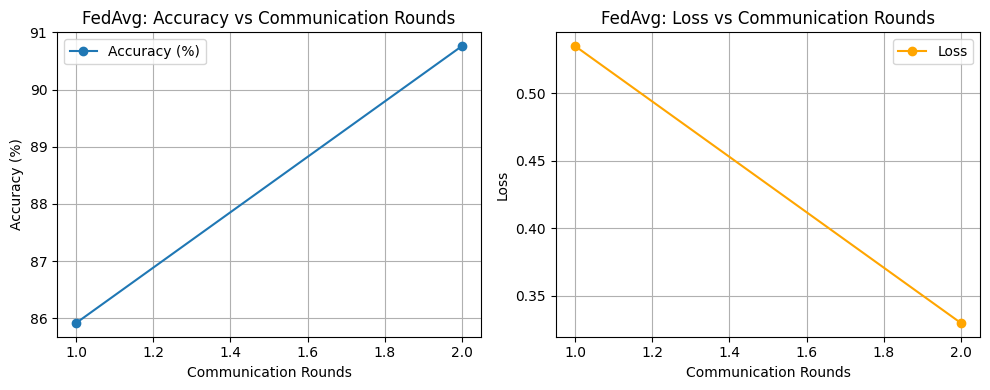


Start FedSGD | iid=True | Target accuracy=90.00% | Timeout=120 seconds | Clients=10 | Sample clients=0.5 | Epoch=2 | Batch size=64 | Learning rate=0.01 | Momentum=0.0
	Round   1 | acc=44.35% | loss=2.1592 | elapsed=0.00 seconds
	Round   2 | acc=18.12% | loss=2.5879 | elapsed=55.41 seconds
	Round   3 | acc=18.95% | loss=2.3167 | elapsed=111.28 seconds
	Timeout at 167.21 seconds.
	Saved mnist_cnn_fedsgd.pt | best_acc=44.35% | rounds=3 | time=167.22 seconds


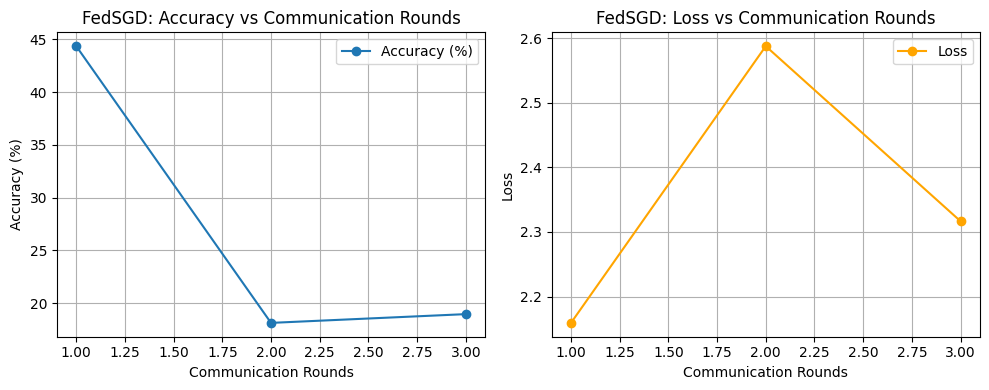

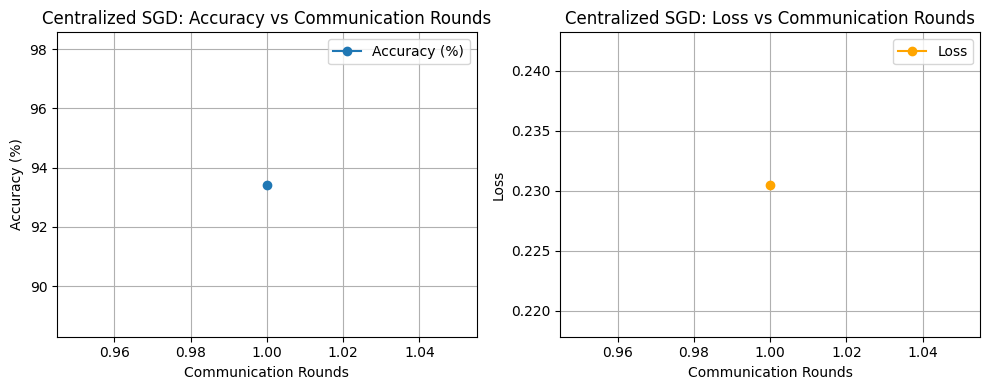


=== IID with inline speedups (baseline=SGD) ===

=== Summary Table ===
  algo  iid  num_clients  sample_frac  local_epochs  batch_size   lr  momentum  target_acc  timeout_min  reached_target  best_acc_%  rounds_run  total_time_min     r@80%     r@82%     r@85%     r@88%     r@90%
FedAvg True           10          0.5             2          64 0.01       0.0         0.9          2.0            True       90.76           2            3.33 1 (×1.00) 1 (×1.00) 1 (×1.00) 2 (×0.50) 2 (×0.50)
FedSGD True           10          0.5             2          64 0.01       0.0         0.9          2.0           False       44.35           3            2.79         -         -         -         -         -
   SGD True           10          0.5             2          64 0.01       0.0         0.9          2.0            True       93.43           1            1.69         1         1         1         1         1

Start FedAvg | iid=False | Target accuracy=90.00% | Timeout=120 seconds | Clients=10 | 

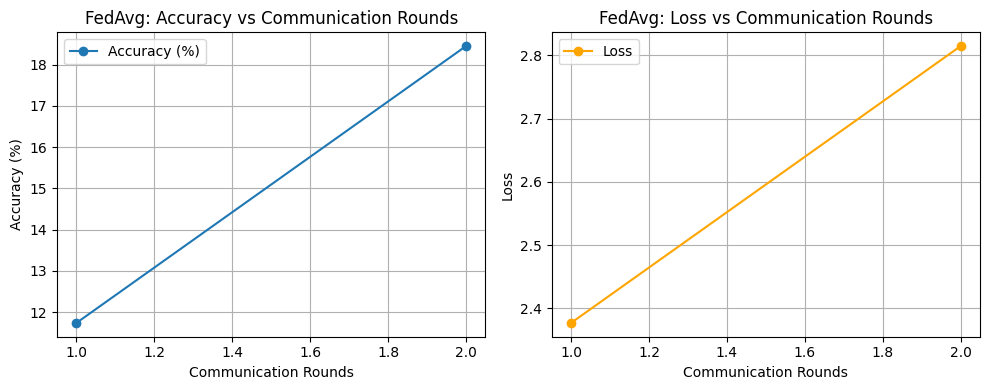


Start FedSGD | iid=False | Target accuracy=90.00% | Timeout=120 seconds | Clients=10 | Sample clients=0.5 | Epoch=2 | Batch size=64 | Learning rate=0.01 | Momentum=0.0
	Round   1 | acc=10.35% | loss=3.9426 | elapsed=0.00 seconds
	Round   2 | acc=11.35% | loss=2.3281 | elapsed=55.27 seconds
	Round   3 | acc=11.35% | loss=2.3079 | elapsed=109.57 seconds
	Timeout at 162.48 seconds.
	Saved mnist_cnn_fedsgd.pt | best_acc=11.35% | rounds=3 | time=162.49 seconds


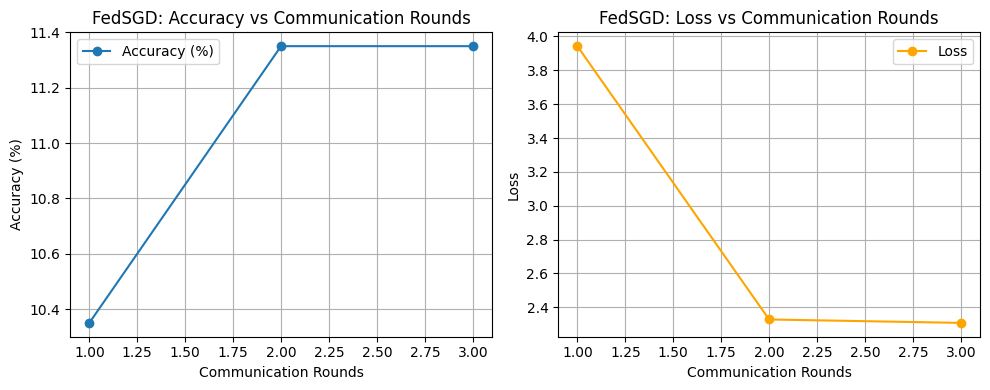

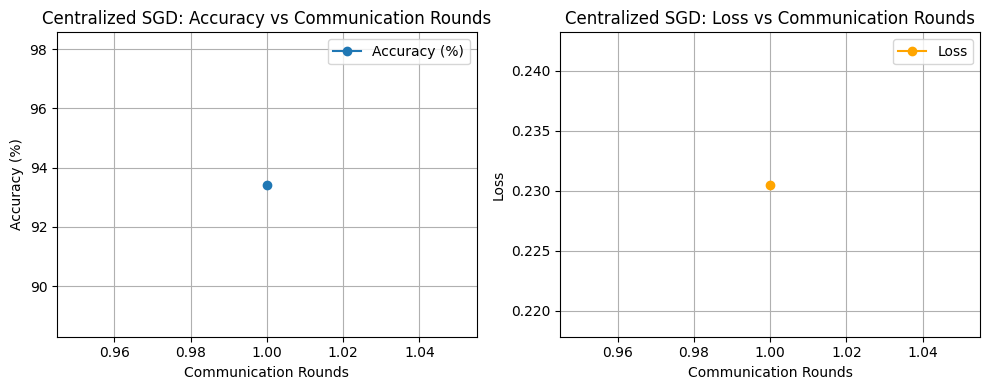


=== non-IID with inline speedups (baseline=SGD) ===

=== Summary Table ===
  algo   iid  num_clients  sample_frac  local_epochs  batch_size   lr  momentum  target_acc  timeout_min  reached_target  best_acc_%  rounds_run  total_time_min r@80% r@82% r@85% r@88% r@90%
FedAvg False           10          0.5             2          64 0.01       0.0         0.9          2.0           False       18.45           2            3.31     -     -     -     -     -
FedSGD False           10          0.5             2          64 0.01       0.0         0.9          2.0           False       11.35           3            2.71     -     -     -     -     -
   SGD False           10          0.5             2          64 0.01       0.0         0.9          2.0            True       93.43           1            1.66     1     1     1     1     1


In [91]:
rows_iid = []
rows_iid.append(run_experiment("FedAvg", iid=True,  target_acc=0.90, timeout_secs=2*60, plot=True))
rows_iid.append(run_experiment("FedSGD", iid=True,  target_acc=0.90, timeout_secs=2*60, plot=True))
rows_iid.append(run_experiment("SGD",    iid=True,  target_acc=0.90, timeout_secs=2*60, plot=True))
results_iid = build_results_table(rows_iid)
results_iid = add_inline_speedup(results_iid, baseline_algo="SGD")
print("\n=== Summary Table ===")
print(results_iid.to_string(index=False))
# results_iid.to_csv("results_summary.csv", index=False)

rows_non_iid = []
rows_non_iid.append(run_experiment("FedAvg", iid=False, target_acc=0.90, timeout_secs=2*60, plot=True))
rows_non_iid.append(run_experiment("FedSGD", iid=False, target_acc=0.90, timeout_secs=2*60, plot=True))
rows_non_iid.append(run_experiment("SGD",    iid=False, target_acc=0.90, timeout_secs=2*60, plot=True))
results_non_iid = build_results_table(rows_non_iid)
results_non_iid = add_inline_speedup(results_non_iid, baseline_algo="SGD")
print("\n=== Summary Table ===")
print(results_non_iid.to_string(index=False))
# results_non_iid.to_csv("results_summary.csv", index=False)